In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

%load_ext autoreload
%autoreload 2

In [2]:
'''
Information about the dataset

#uv and green?
#input downscale from 72 to 18? (input-mean)/std?
#input with no preprocessing, to keep it consistent with autoencoder model where downscale from 56 to 28, input-mean
#how many time lags? ... 30 time lags
'mean': 36.979288270899204, 'sd': 36.98463253226166

These fields may use different random seed of stimulus presentation sequence
"1_ventral1_20210929": 07
"2_ventral1_20210929": 10
"1_ventral2_20210929": 08
"2_ventral2_20210929": 18
"3_ventral2_20210929": 19
"4_ventral2_20210929": 09
"5_ventral2_20210929": 19
"1_ventral1_20210930": 05
"1_ventral2_20210930": 07
"2_ventral2_20210930": 06
"3_ventral2_20210930": 09
'''

'\nInformation about the dataset\n\n#uv and green?\n#input downscale from 72 to 18? (input-mean)/std?\n#input with no preprocessing, to keep it consistent with autoencoder model where downscale from 56 to 28, input-mean\n#how many time lags? ... 30 time lags\n\'mean\': 36.979288270899204, \'sd\': 36.98463253226166\n\nThese fields may use different random seed of stimulus presentation sequence\n"1_ventral1_20210929": 07\n"2_ventral1_20210929": 10\n"1_ventral2_20210929": 08\n"2_ventral2_20210929": 18\n"3_ventral2_20210929": 19\n"4_ventral2_20210929": 09\n"5_ventral2_20210929": 19\n"1_ventral1_20210930": 05\n"1_ventral2_20210930": 07\n"2_ventral2_20210930": 06\n"3_ventral2_20210930": 09\n'

In [3]:
with open(r'train_inputs.pkl', "rb") as f:
    train_inputs = pkl.load(f)
with open(r'train_targets.pkl', "rb") as f:
    train_targest = pkl.load(f)

with open(r'test_inputs.pkl', "rb") as f:
    test_inputs = pkl.load(f)
with open(r'test_targets.pkl', "rb") as f:
    test_targest = pkl.load(f)

In [4]:
train_inputs.keys()

dict_keys(['1_ventral1_20210929', '2_ventral1_20210929', '1_ventral2_20210929', '2_ventral2_20210929', '3_ventral2_20210929', '4_ventral2_20210929', '5_ventral2_20210929', '1_ventral1_20210930', '1_ventral2_20210930', '2_ventral2_20210930', '3_ventral2_20210930'])

In [5]:
# preprocess, torch to array, undo normalization, float to int, transpose
fieldname = '4_ventral2_20210929'
datamean, datasd = 36.98, 36.98
train_input1 = np.transpose((np.around(train_inputs[fieldname].cpu().detach().numpy()*datasd+datamean)).astype(int), (1,0,2,3))
train_response1 = train_targest[fieldname].cpu().detach().numpy()
test_input1 = np.transpose((np.around(test_inputs[fieldname].cpu().detach().numpy()*datasd+datamean)).astype(int), (1,0,2,3))
test_response1 = test_targest[fieldname].cpu().detach().numpy()
print (train_input1.shape, np.min(train_input1,axis=(0,2,3)), np.max(train_input1)) # green+UV
print (train_response1.shape)
print (test_input1.shape, np.min(test_input1,axis=(0,2,3)), np.max(test_input1))
print (test_response1.shape)

#resize images
scale = 0.5
temps = np.zeros((train_input1.shape[0], train_input1.shape[1], int(train_input1.shape[2]*scale),\
                  int(train_input1.shape[3]*scale)), dtype=np.uint8)
for ii in range(len(temps)):
    temp = np.zeros((train_input1.shape[2], train_input1.shape[3],3), dtype=np.uint8)
    temp[:,:,:2]=np.transpose(train_input1[ii], (1,2,0))
    temp = np.uint8(np.around((cv2.resize(temp/255.0, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA))*255.0))
    temps[ii] = np.transpose(temp[:,:,:2], (2,0,1))
train_input1 = np.copy(temps)
print (train_input1.shape, np.min(train_input1,axis=(0,2,3)), np.max(train_input1)) 
temps = np.zeros((test_input1.shape[0], test_input1.shape[1], int(test_input1.shape[2]*scale),\
                  int(test_input1.shape[3]*scale)), dtype=np.uint8)
for ii in range(len(temps)):
    temp = np.zeros((test_input1.shape[2], test_input1.shape[3],3), dtype=np.uint8)
    temp[:,:,:2]=np.transpose(test_input1[ii], (1,2,0))
    temp = np.uint8(np.around((cv2.resize(temp/255.0, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA))*255.0))
    temps[ii] = np.transpose(temp[:,:,:2], (2,0,1))
test_input1 = np.copy(temps)
print (test_input1.shape, np.min(test_input1,axis=(0,2,3)), np.max(test_input1)) 

(16200, 2, 72, 64) [14  5] 255
(16200, 86)
(750, 2, 72, 64) [14  5] 255
(750, 86)
(16200, 2, 36, 32) [14  5] 255
(750, 2, 36, 32) [14  5] 255


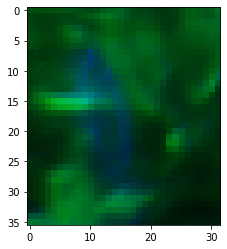

In [6]:
tempbgr=np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(test_input1[370],(1,2,0))[...,::-1]
plt.imshow(tempbgr[:,:,::-1])

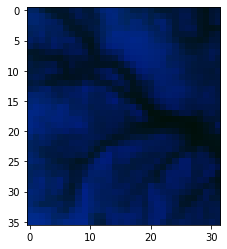

In [7]:
tempbgr=np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(train_input1[1300],(1,2,0))[...,::-1]
plt.imshow(tempbgr[:,:,::-1])

# Generate data loader for model training

In [ ]:
def get_sdm(stim, nlag):    
    """
    Get stimulus design matrix. 
    ::nlag: time lag, how many frames of the stimulus we 
            assumed to trigger the response. nlag = 5 is good enough for
            our data.
    """
    n_samples = stim.shape[0]
    n_features = stim.shape[1:]
    frames = np.zeros([n_samples, np.prod(n_features) * nlag])
    for i in range(n_samples):
        if i < nlag-1:
            pad = np.zeros([nlag-i-1, *n_features])
            frame = np.ravel(np.vstack([pad, stim[:i+1]]))
        else:
            frame = np.ravel(stim[i-nlag+1:i+1])
        frames[i] = frame
    return frames

## time lag 50

In [94]:
#save train and test stimulus separately
nt = 50 # time lag
nh = 36
nw = 32
dims = [nt, nh, nw]

Stim=train_input1[:,1,:,:]
X_UV = get_sdm(Stim, nt)
X_UV = np.reshape(X_UV,(-1,nt,nh,nw))
X_UV = np.expand_dims(X_UV,axis=1)
Stim=train_input1[:,0,:,:]
X_G = get_sdm(Stim, nt)
X_G = np.reshape(X_G,(-1,nt,nh,nw))
X_G = np.expand_dims(X_G,axis=1)
train_input2=np.concatenate((X_UV,X_G),axis=1).astype(np.uint8) #UV+g
print (train_input2.shape) #shape: batch_size,color_channel,time_lags,height,width
#
Stim=test_input1[:,1,:,:]
X_UV = get_sdm(Stim, nt)
X_UV = np.reshape(X_UV,(-1,nt,nh,nw))
X_UV = np.expand_dims(X_UV,axis=1)
Stim=test_input1[:,0,:,:]
X_G = get_sdm(Stim, nt)
X_G = np.reshape(X_G,(-1,nt,nh,nw))
X_G = np.expand_dims(X_G,axis=1)
test_input2=np.concatenate((X_UV,X_G),axis=1).astype(np.uint8) #UV+g
print (test_input2.shape) #shape: batch_size,color_channel,time_lags,height,width

(16200, 2, 50, 36, 32)
(750, 2, 50, 36, 32)


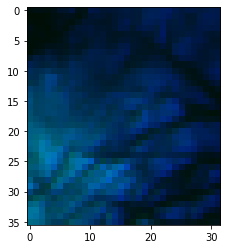

In [96]:
tempbgr=np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(train_input2[370,:,10],(1,2,0))
plt.imshow(tempbgr[:,:,::-1])

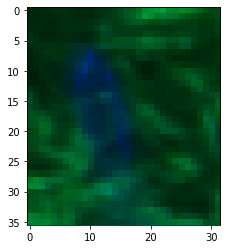

In [97]:
tempbgr=np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(test_input2[370,:,10],(1,2,0))
plt.imshow(tempbgr[:,:,::-1])

In [98]:
#np.save('natural_20210929ventral_train_input_tlag50.npy', train_input2)
#np.save('natural_20210929ventral_test_input_tlag50.npy', test_input2)

In [95]:
np.max(test_input2), np.min(test_input2[50:])

(255, 5)